# Sale Price Prediction Notebook

Part of CRISP-DM Modelling and Evaluation

## Objectives
* Simplify the code from previous notebook.

## Inputs
* outputs/datasets/collection/house_prices_records.csv

## Outputs
* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature importance plot

## Additional Comments

---

## Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [43]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [44]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new directory

In [45]:
current_dir = os.getcwd()
current_dir

'/workspace'

## Load Data

In [46]:
import numpy as py
import pandas as pd

df = pd.read_csv(f"outputs/datasets/collection/house_prices_records.csv")
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/datasets/collection/house_prices_records.csv'

## ML Pipeline: Regression

### Create the ML Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from pandas import MultiIndex, Int64Index

# Data Cleaning
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer

# Feature Engineering
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML Algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Cleaning Pipeline
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),
        # Feature Engineering
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea'], base='e')),
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'TotalBsmtSF', 'GarageArea'])),
        ("NumericPowerTransform", vt.PowerTransformer(variables=['LotArea'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
        ("SmartCorrelationSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        # Feature Scaling
        ("scaler", StandardScaler()),
        # Feature Selection
        ("feat_selection", SelectFromModel(model)),
        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/tmp/ipykernel_12403/2303324023.py:2: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom class for hyperparameter optimisation:

In [ ]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
     "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

We will use deault hyperparameters first to find most suitable algorithm:

In [ ]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Complete Hyperparameter optimization using the default hyperparameters

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be re

In [ ]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.77533,0.845186,0.069533
2,RandomForestRegressor,0.61857,0.761996,0.821982,0.073466
3,ExtraTreesRegressor,0.680311,0.761302,0.792766,0.041871
0,LinearRegression,0.689896,0.739884,0.822031,0.044905
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922


In [ ]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

## Most suitable hyperparameters

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.05],
        'model__min_samples_split': [75],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [50],
    }
}

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.748757,0.795597,0.845302,0.034696,0.05,3,50,1,75,100


In [ ]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05,
 'model__max_depth': 3,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 75,
 'model__n_estimators': 100}

In [ ]:
best_pipeline_regression = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variable...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond

## Assess Feature Importance

* These are the 4 most important features in descending order. The model was trained on them: 
['2ndFlrSF', 'GarageArea', 'OverallQual', 'TotalBsmtSF']


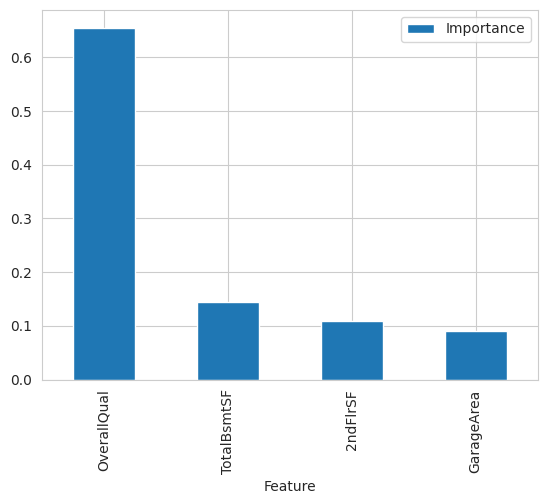

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline_regression.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_pipeline_regression['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_pipeline_regression['feat_selection'].get_support()],
          'Importance': best_pipeline_regression['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].tick_params(axis='x', rotation=90)
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].tick_params(axis='x', rotation=90)
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.875
Mean Absolute Error: 19832.825
Mean Squared Error: 766660950.577
Root Mean Squared Error: 27688.643


* Test Set
R2 Score: 0.833
Mean Absolute Error: 22342.945
Mean Squared Error: 1151982096.592
Root Mean Squared Error: 33940.862




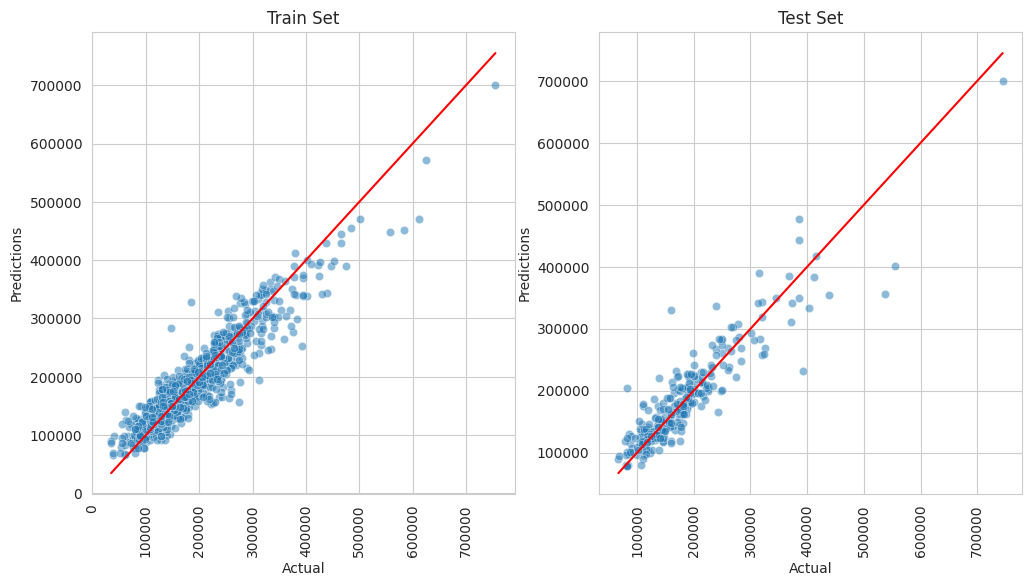

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_regression)

The R2 Score on the test set is 0.83. It passes the performance goal of atleast 0.8.

## Rewriting the ML Pipeline

Use only the steps that affect the most important features identified: '2ndFlrSF', 'GarageArea', 'OverallQual', 'TotalBsmtSF'

In [ ]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])),
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.05],
        'model__min_samples_split': [75],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [50],
    }
}

## Split Train and Test Sets with Best Features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
618,0.0,774,9,1822
870,0.0,308,5,894
92,0.0,432,5,876


In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Grid Search



In [ ]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.748757,0.798189,0.824882,0.026365,0.05,3,50,1,75,100


In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [ ]:
pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF',
                                                  'GarageArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           max_leaf_nodes=50,
                                           min_samples_split=75,
                                           random_state=0))])

Model Evaluation 

* Train Set
R2 Score: 0.875
Mean Absolute Error: 19832.825
Mean Squared Error: 766660950.577
Root Mean Squared Error: 27688.643


* Test Set
R2 Score: 0.833
Mean Absolute Error: 22342.945
Mean Squared Error: 1151982096.592
Root Mean Squared Error: 33940.862




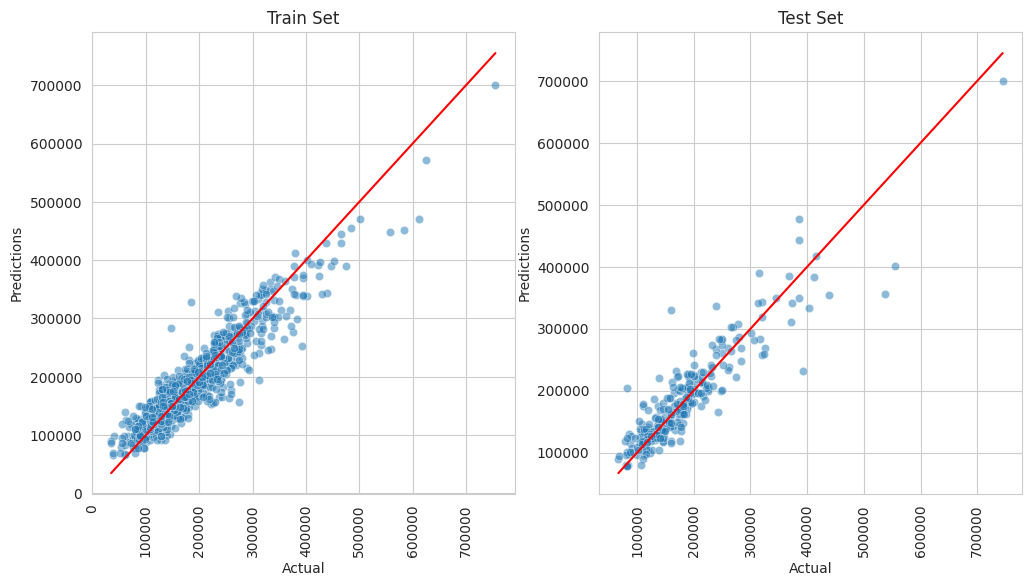

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

The simplified version of our pipeline retains the level of performance as the first pipeline. We will save this as v2 and push it to the repository.

---

## Push files to repo

The following files will be created and pushed to the repo:

* Train Set
* Test Set
* Modeling Pipeline
* Feature importance Plot

In [ ]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/sale_price_prediction/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/sale_price_prediction/v2'


## Train Set: Features & Target

In [ ]:
X_train.head()

,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
618,0.0,774,9,1822
870,0.0,308,5,894
92,0.0,432,5,876
817,0.0,857,8,1568
302,0.0,843,7,1541


In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [ ]:
X_test.head()

,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
529,0.0,484,6,2035
491,620.0,240,6,806
459,224.0,352,5,709
279,866.0,505,7,1160
655,NaN,264,6,525


In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Model Pipeline

In [ ]:
pipeline_regression

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF',
                                                  'GarageArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           max_leaf_nodes=50,
                                           min_samples_split=75,
                                           random_state=0))])

In [ ]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/sale_price_prediction/v2/regression_pipeline.pkl']

## Feature Importance Plot

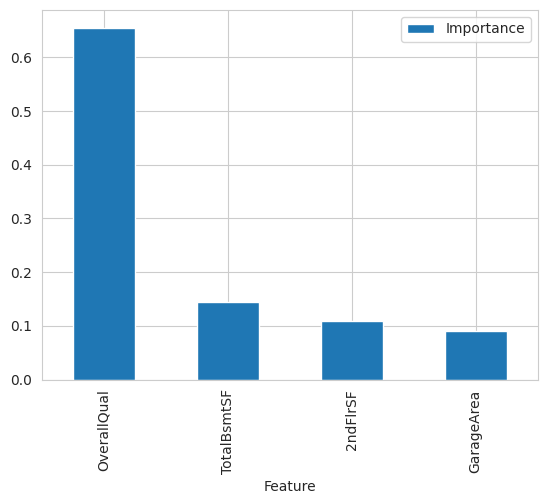

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

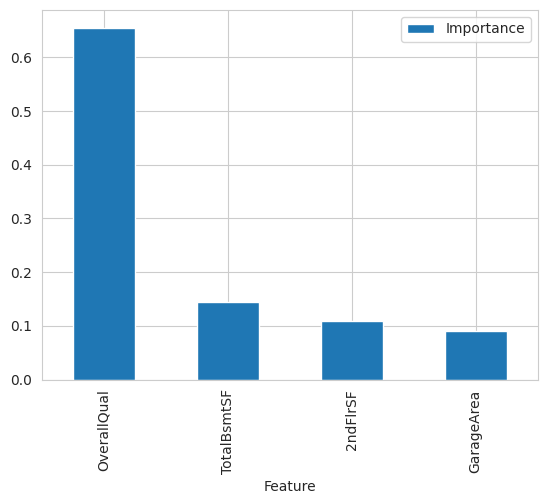

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

---

## Conclusions

* A pipeline was created for best features
* The plot for best features shows that variables that have a relation to: size, quality and age of the property have high predictive power
* From the hypothesis we can conclude that:
* - The quality of the property has the biggest correlation to the sale price.
* - The square footage of elements in the property effects the sale price of the propety.